# Two-view Geometry

- 학번 : 20233142
- 이름 : 벅정은

---

- 두 이미지 평면 사이의 기하학적 관계를 이용해 강건한 특징 매칭을 획득한다.


**참고**
- Colab에서 코드에 이상이 없음에도 불구하고 결과가 제대로 나오지 않을 경우, '런타임 다시 시작...'을 해보도록 한다.

---

**[중요] 과제 제출 방법**
- 과제 제출 기한은 가상대학 공지사항을 참고하세요.
- 과제는 Colab에서 작성한 것을 다운받아 (파일 > 다운로드 > .ipynb 다운로드) 가상 대학에 업로드합니다. (이외의 제출 방법은 인정하지 않음)
- 제출 시 파일 제목은 '학번_이름' 으로 저장합니다.

In [1]:
import sys
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

print('python', sys.version)
print('numpy', np.__version__)
print('opencv', cv.__version__)

python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy 1.25.2
opencv 4.8.0


In [2]:
# mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ROOT = '/content/drive/My Drive/Colab Notebooks/Vehicle Intelligence/img/'

### opencv를 사용해 이미지 불러오기

- `cv.imread()`를 이용해 이미지를 불러오면 RGB가 아닌 BGR 이미지임을 유의해야 한다.

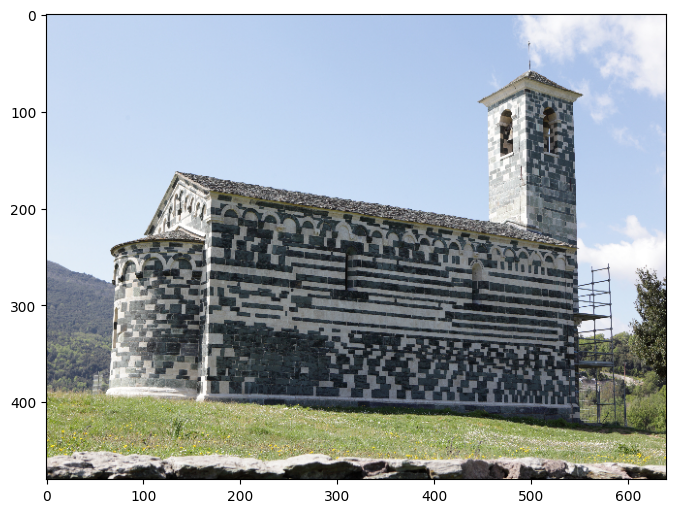

In [4]:
img1 = cv.imread(ROOT + 'two_view/DPP_0010.png')
img2 = cv.imread(ROOT + 'two_view/DPP_0011.png')

plt.figure(figsize=(8,8))
plt.imshow(img1[:,:,::-1])
plt.show()

### ORB feature 얻기

- 두 장의 영상에 대한 ORB feature를 얻는다.

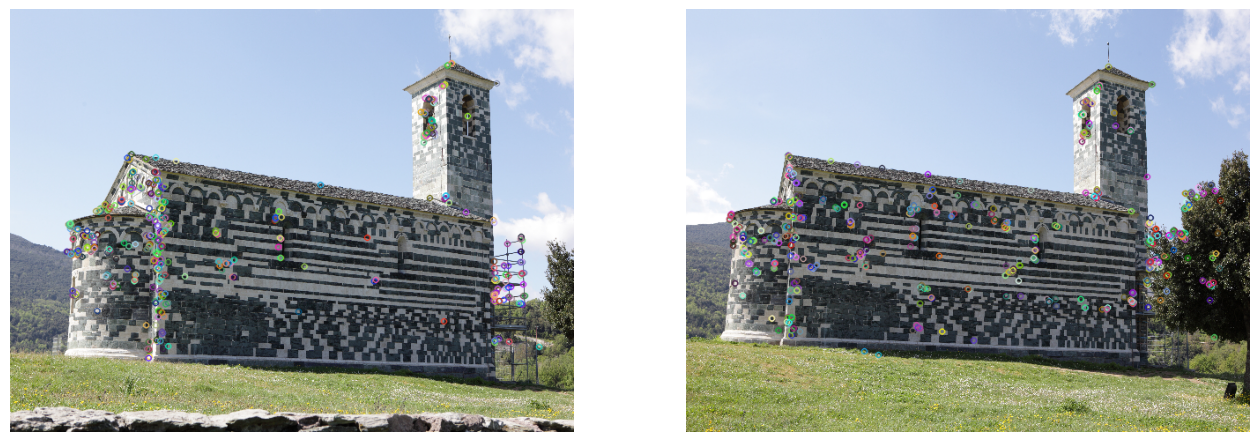

In [5]:
# To-do
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

retval = cv.ORB_create()
# gray에서 ORB 키포인트와 desc 구하기
orb_kps1, desc1 = retval.detectAndCompute(gray1,None)
orb_kps2, desc2 = retval.detectAndCompute(gray2,None)
#img에 검출된 ORB 키포인트들을 그리기.
orb_kps_img1 = cv.drawKeypoints(img1, orb_kps1, None)
orb_kps_img2 = cv.drawKeypoints(img2, orb_kps2, None)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(orb_kps_img1[:,:,::-1])
plt.axis('off')
plt.subplot(122)
plt.imshow(orb_kps_img2[:,:,::-1])
plt.axis('off')
plt.show()

### Feature Matching

- brute-force matcher를 이용해 ORB feature에 대한 매칭을 진행한다.

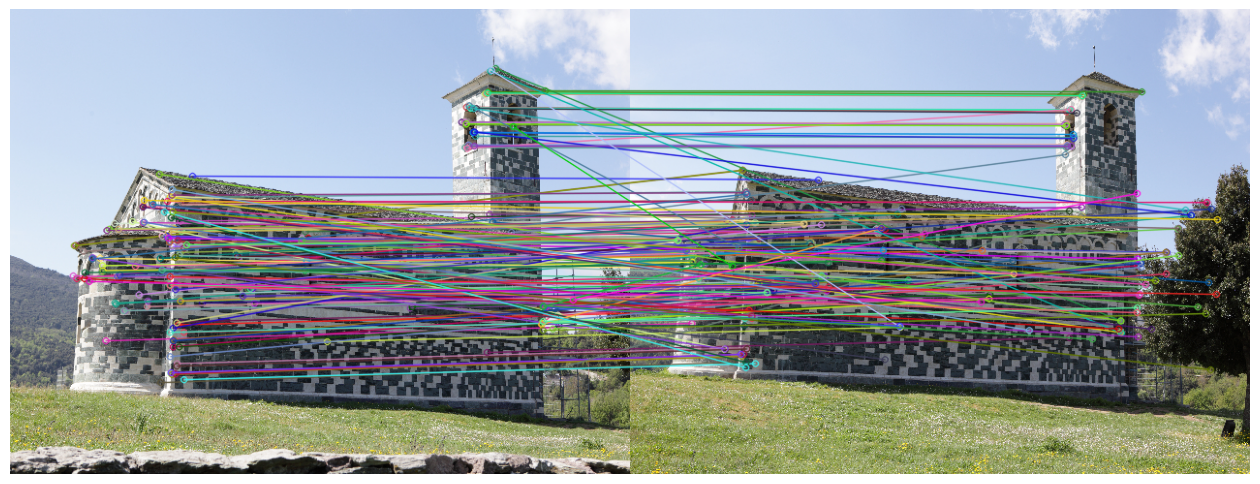

In [6]:
#To-do

matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
#crossCheck=True 활성화하여 매칭된 쌍이 일치하는지 확인
matches = matcher.match(desc1,desc2)
matches = sorted(matches, key = lambda x:x.distance) #거리기준으로 정렬하기
match_img = cv.drawMatches(img1,orb_kps1,img2, orb_kps2,matches[:400],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#두 이미지의 키포인트와 매칭된 쌍을 시각적으로 연결하여 표시
#상위 400개의 매칭만을 사용
#flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS는 매칭되지 않은 키포인트는 그리지 않도록 설정하는 옵션
plt.figure(figsize=(16,8))
plt.imshow(match_img[:,:,::-1])
plt.axis('off')

plt.show()

### 매칭된 feature 저장하기

In [7]:
# 이 부분은 수정하지 않습니다.

pts1 = []
pts2 = []

for i, m in enumerate(matches):
  pts1.append(orb_kps1[m.queryIdx].pt)
  pts2.append(orb_kps2[m.trainIdx].pt)

pts1 = np.array(pts1, dtype=np.float32)
pts2 = np.array(pts2, dtype=np.float32)

## Fundamental Matrix


**과제**
- 두 장의 이미지에 대한 Fundamental matrix를 구하시오.
- 함수의 출력값인 mask를 이용해 원래 매칭 `pts1`, `pts2`에서 outlier를 제거한 `pts1_F`, `pts2_F`를 구하시오.

관련 함수

`retval, mask	=	cv.findFundamentalMat(	points1, points2, method, ransacReprojThreshold, confidence, maxIters[, mask]	)`


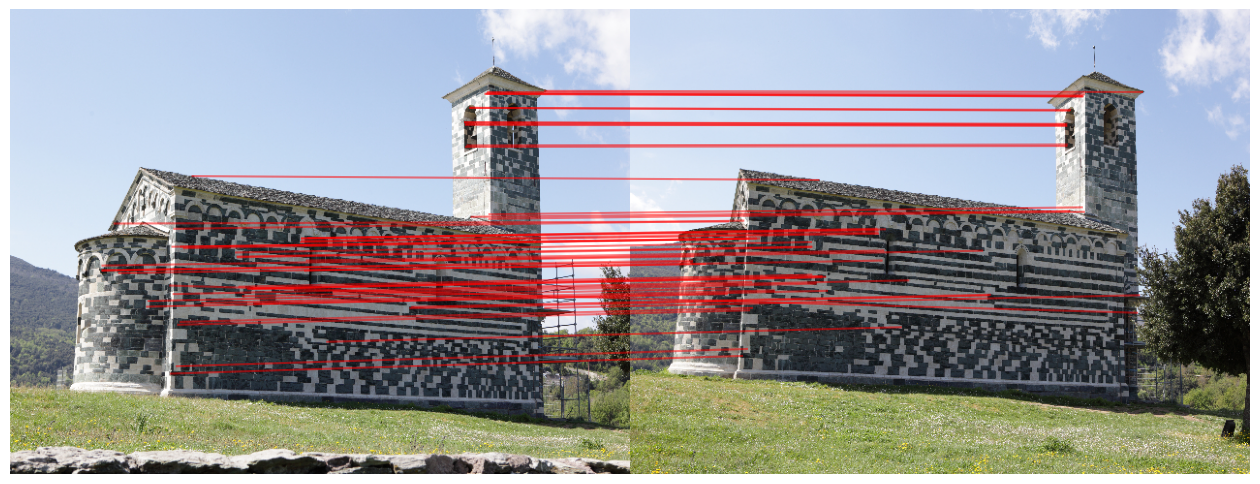

걸러진 매칭 개수 :  128


In [8]:
# To-do
#RANSAC은 매 반복에서, 알고리즘을 통해 대응 세트 중에 5개의 점을 임의로 뽑고
#Essential Matrix 를 추정. 이 Essential Matrix 를 사용할 때 다른 점들이 inlier 인지 확인함
#정해진 반복을 수행한 후 종료되며, 포인트의 수가 최대가 되는 경우의 Essential Matrix 를 사용

ret, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC, 1.0, 0.99)
#pts1, pts2을 사용하여 기본 행렬 계산
#cv.FM_RANSAC: RANSAC알고리즘을 사용하여 outlier을 제거하면서 기본 행렬을 추정하는 옵션
#1.0: RANSAC 알고리즘에서 허용되는 거리 오차(픽셀 단위)
#0.99는 신뢰도

pts1_F = pts1[mask.ravel() == 1] #만약 아웃라이어면 0, 인라이어는 1임.
pts2_F = pts2[mask.ravel() == 1]
#mask에서 인라이어 점들만 추출해서 pts1_F, pts2_F에 저장하기

# 이 부분은 수정하지 않습니다.
img = np.concatenate([img1,img2], axis=1)

plt.figure(figsize=(16,8))
plt.imshow(img[:,:,::-1])
plt.plot([pts1_F[:,0], 640 + pts2_F[:,0]], [pts1_F[:,1], pts2_F[:,1]], 'r-', alpha=0.5)
plt.axis('off')
plt.show()

print('걸러진 매칭 개수 : ', len(pts1) - len(pts1_F))

## Essential Matrix


**과제**
- 두 장의 이미지에 대한  Essential Matrix를 구하시오.
- 위와 같은 방법으로 `pts1_E`, `pts2_E`를 구하시오.

관련 함수

`retval, mask	=	cv.findEssentialMat(	points1, points2[, focal[, pp[, method[, prob[, threshold[, mask]]]]]]	)`


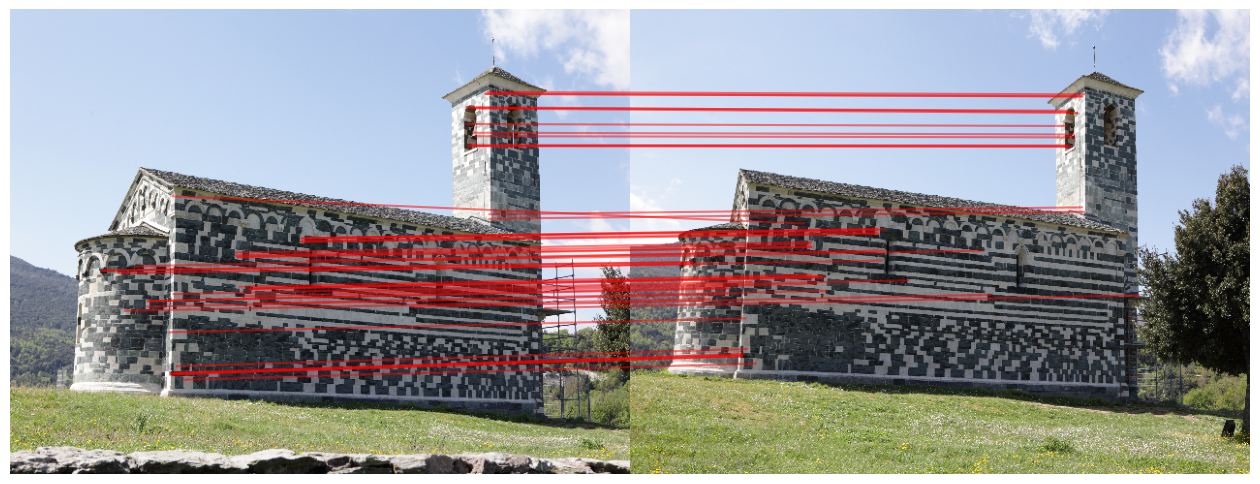

걸러진 매칭 개수 :  133


In [9]:
focal = 640.0 #카메라의 초점 거리를 설정
pp = (320, 240) #카메라의 주점(principal point) 즉, 이미지의 중심점 좌표를 설정

# To-do
E, mask = cv.findEssentialMat(pts1, pts2, focal=focal, pp=pp, method=cv.RANSAC, prob=0.999, threshold=1.0)
#prob=0.999: RANSAC 알고리즘의 신뢰도
#threshold=1.0: RANSAC 알고리즘에서 허용되는 거리 오차(픽셀 단위)

pts1_E = pts1[mask.ravel() == 1]
pts2_E = pts2[mask.ravel() == 1]

#findEssentialMat 함수는 OpenCV에서 두 이미지 간의 매칭된 점들을 사용하여 필수 행렬(Essential Matrix)을 계산하는 함수
# 두 카메라의 뷰 사이의 관계, 카메라 모션 등을 표현하는데 사용

# 이 부부은 수정하지 않습니다.
img = np.concatenate([img1, img2], axis=1)

plt.figure(figsize=(16,8))
plt.imshow(img[:,:,::-1])
plt.plot([pts1_E[:,0], 640 + pts2_E[:,0]], [pts1_E[:,1], pts2_E[:,1]], 'r-', alpha=0.5)
plt.axis('off')
plt.show()

print('걸러진 매칭 개수 : ', len(pts1) - len(pts1_E))

## 두 이미지 사이의 회전 행렬과 이동 벡터 찾기

**과제**
- 위에서 구한 Essential Matix를 이용해 회전 행렬과 이동 벡터을 구하시오.
  - inlier의 갯수와 구한 회전 행렬, 이동 벡터를 출력할 것
- 위와 같은 방법으로 `pts1_P`, `pts2_P`를 구하시오.
- `cv.decomposeEssentialMat()`함수를 찾아보고 `cv.recoverPose()`함수와의 차이점을 설명하시오.

관련 함수

- `retval, R, t, mask	=	cv.recoverPose(	E, points1, points2[, R[, t[, focal[, pp[, mask]]]]])`


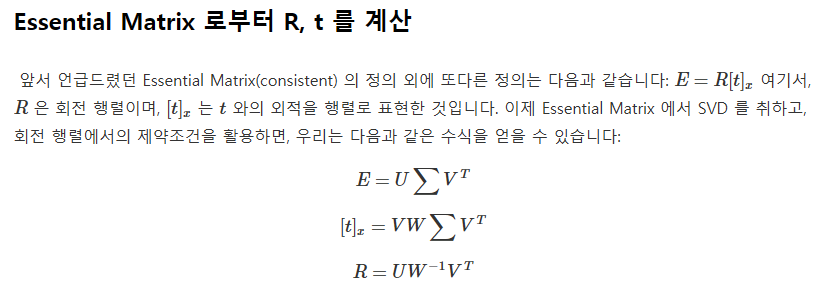

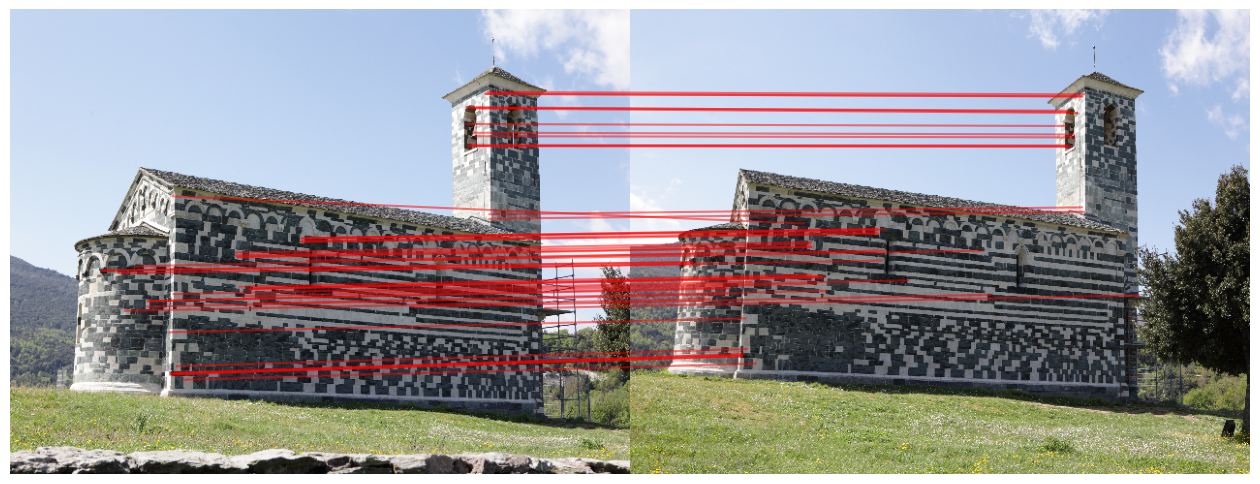

In [10]:
# To-do
retval, R, t, mask = cv.recoverPose(E, pts1_E, pts2_E, focal=focal, pp=pp)
#반환값:
# 1. retval: 복구된 점의 개수
# 2. R: 두 번째 카메라 좌표계에 대한 첫 번째 카메라 좌표계의 회전 행렬
# 3. t: 두 번째 카메라 좌표계에 대한 첫 번째 카메라 좌표계의 번역 벡터
pts1_P = pts1_E[mask.ravel() == 255] #인라이어를 255로 표시. 아웃라이어는 0
pts2_P = pts2_E[mask.ravel() == 255]

#cv.decomposeEssentialMat() 함수는 필수 행렬을 분해하여 가능한 두 개의 회전 행렬과 두 개의 번역 벡터를 추출함
#     ㄴ> 필수행렬을 분해하여 가능한 모션 솔루션 여러개 반환
#cv.recoverPose() 함수는 필수 행렬과 매칭된 점들을 사용하여 카메라 모션을 복구함.
# => 두 이미지의 매칭된 점들로부터 하나의 회전 행렬과 번역 벡터를 반환
#       ㄴ> 매칭을 고려하여 최적의 모션 솔루션을 1개 제공함

# 이 부분은 수정하지 않습니다.
img = np.concatenate([img1, img2], axis=1)

plt.figure(figsize=(16,8))
plt.imshow(img[:,:,::-1])
plt.plot([pts1_P[:,0], 640 + pts2_P[:,0]], [pts1_P[:,1], pts2_P[:,1]], 'r-', alpha=0.5)
plt.axis('off')
plt.show()

#참고: https://snacky.tistory.com/98

### 시각화

다음 코드는 두 이미지의 회전/이동 관계를 시각화하는 코드이다.

**과제**
- 다음 코드를 해석하여 설명하시오. (주석, markdown 모두 허용)

In [11]:

def draw_axis_3dax(ax, R, t, scale=0.1): #카메라 좌표 축을 3D그래프에 그리는 함수
#ax: matplotlib의 3D 축 객체. 3D 그래프를 그리기 위해 사용
#R: 카메라의 회전 정보를 담고 있는 회전행렬
#t: 카메라의 위치 정보를 담고 있는 번역벡터
#scale: 축의 길이를 조절하는 스케일링 인자. 기본값이 0.1임
    xaxis = t + R[:,0]*scale #회전 행렬 R의 첫 번째 열은 카메라 좌표계에서의 x축 방향 벡터를 나타냄. -> 스케일을 곱하여 축 길이 조절
#             ㄴ> t + R[:,0]*scale은 x축의 끝점을 계산
    yaxis = t + R[:,1]*scale #회전 행렬 R의 두 번째 열은 y축 방향 벡터를 나타냄.
#               ㄴ> y축의 끝점 계산
    zaxis = t + R[:,2]*scale
#               ㄴ> z축의 끝점 계산
# [t[0], xaxis[0]], [t[1], xaxis[1]], [t[2], xaxis[2]]는 각각 x, y, z 좌표의 시작점과 끝점을 나타내고 있음.
    ax.plot([t[0], xaxis[0]], [t[1], xaxis[1]], [t[2], xaxis[2]], 'r-') #빨간색(x축)
    ax.plot([t[0], yaxis[0]], [t[1], yaxis[1]], [t[2], yaxis[2]], 'g-') #녹색(y축)
    ax.plot([t[0], zaxis[0]], [t[1], zaxis[1]], [t[2], zaxis[2]], 'b-') #파란색(z축)

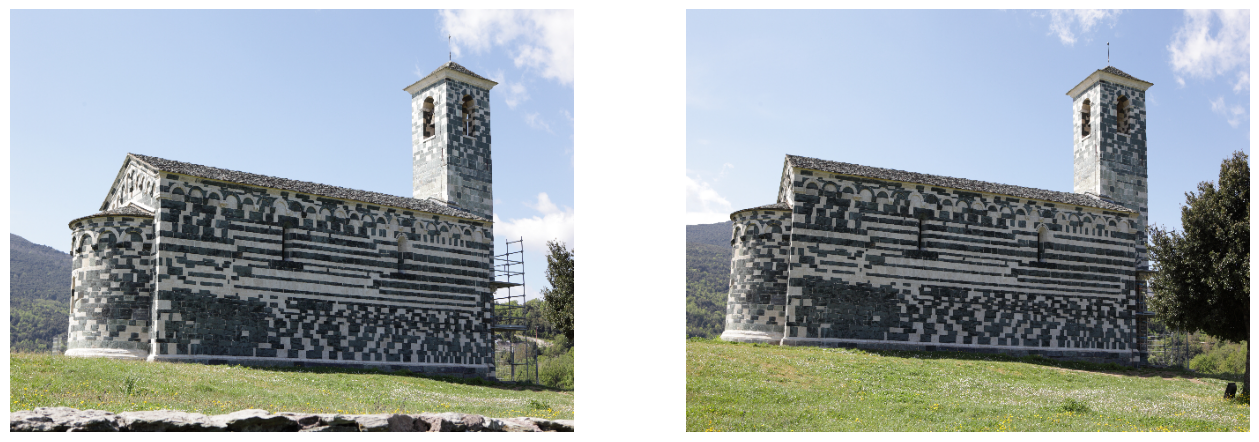

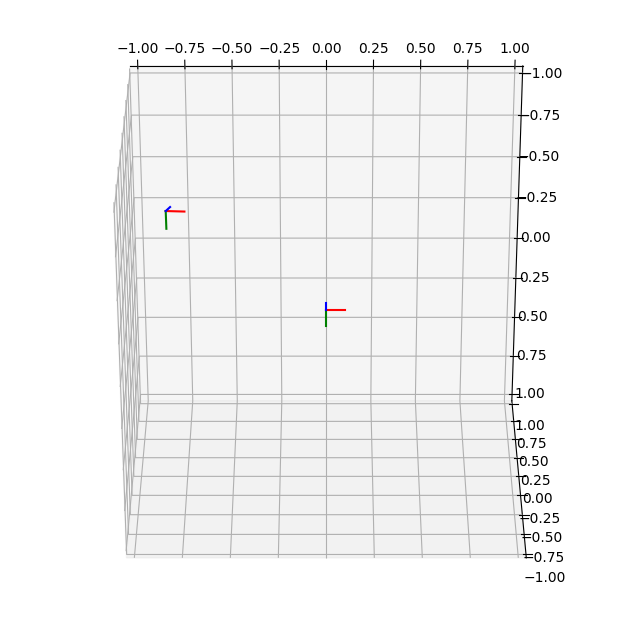

In [15]:
from mpl_toolkits.mplot3d import Axes3D #mpl_toolkits.mplot3d 모듈은 matplotlib 라이브러리의 서브 모듈 중 하나로, 3차원 그래픽을 그리는 데 사용
#Axes3D 클래스는 3차원 그래프를 그리기 위한 Axes 클래스의 서브 클래스

h,w = img1.shape[:2] #img1.shape[:2]: 첫 번째 이미지의 높이(h)와 너비(w)를 가져옴
#max = w/np.maximum(h,w)와 ymax = h/np.maximum(h,w): 이미지를 정규화하여 xmax와 ymax 값을 계산하기.
#      => 이미지 비율을 유지할 때 사용
xmax = w/np.maximum(h,w)
ymax = h/np.maximum(h,w)

#이미지를 40x30 크기로 리사이즈하고, 값의 범위를 [0, 1]로 정규화
img1_n = cv.resize(img1, dsize=(40,30))/255.0
img2_n = cv.resize(img2, dsize=(40,30))/255.0

fig = plt.figure(figsize=(16,8))
plt.subplot(121)
# 첫 번째 이미지를 RGB로 변환하고, extent를 사용하여 이미지를 지정된 범위로 표시
plt.imshow(img1[:,:,::-1], origin='upper', extent=[-xmax,xmax,-ymax,ymax])
plt.axis('off')

plt.subplot(122)
#두 번째 이미지를 RGB로 변환하고, extent를 사용하여 이미지를 지정된 범위로 표시
plt.imshow(img2[:,:,::-1], origin='upper', extent=[-xmax,xmax,-ymax,ymax])
plt.axis('off')

plt.show()

#3D축 시각화
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d') #3D 서브플롯을 추가
#ax.view_init(elev=-60, azim=-90): 3D 플롯의 뷰 각도를 설정. elev는 높이 각도, azim은 방위각
ax.view_init(elev=-60, azim=-90) #즉, 카메라의 각도 설정
draw_axis_3dax(ax, R=np.eye(3), t=np.array([0,0,0])) #첫 번째 좌표 축 그리기,
#R=np.eye(3): 회전이 없음을 의미
#t=np.array([0,0,0]): 원점 나타내기
draw_axis_3dax(ax, R=R, t=np.squeeze(1.0*t, axis=-1)) # 두 번째 좌표 축 그리기
#t=np.squeeze(1.0*t, axis=-1): 주어진 번역벡터

#3D 플롯의 x, y, z 축 범위를 설정
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.set_zlim(-1.0, 1.0)

plt.show()